In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
import tensorflow as tf
from typing import Any
from pathlib import Path
import xml.etree.ElementTree as ET

2026-01-13 22:50:01.648590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-13 22:50:01.673474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-13 22:50:01.693440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-13 22:50:01.738926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 22:50:02.930095: W tensorflow/compiler/tf2

In [3]:
from mobilenetv2ssd.core.config import load_config

In [4]:
main_cfg_path = "configs/train/default.yaml"
model_cfg_path = "configs/model/mobilenetv2_ssd_voc.yaml"
data_cfg_path = "configs/data/voc_224.yaml"
eval_cfg_path = "configs/eval/default.yaml"

In [5]:
config = load_config(main_cfg_path,model_cfg_path,data_cfg_path,eval_cfg_path)

In [6]:
config['data']

{'dataset_name': 'voc',
 'root': '/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012',
 'train_split': 'trainval',
 'val_split': 'val',
 'input_size': [224, 224],
 'num_workers': 4,
 'shuffle_buffer': 1000,
 'prefetch_batches': 2,
 'standardize': {'boxes_format_in': 'xyxy_pixels',
  'boxes_format_out': 'xyxy_pixels',
  'image_rgb': True,
  'to_float32': True,
  'scale': '0_1'},
 'preprocess': {'standardize_pipeline': ['to_float32', 'scale_01'],
  'pipeline': ['resize', 'sanitize_boxes', 'normalize'],
  'params': {'resize': {'enabled': True,
    'size': [300, 300],
    'mode': 'stretch',
    'interp': 'bilinear'},
   'sanitize_boxes': {'enabled': True,
    'clip': True,
    'min_size': 1,
    'min_size_mode': 'pixels'},
   'normalize': {'enabled': True,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]}}},
 'augment': {'enabled': True,
  'output_box_norm': True,
  'pipeline': ['photometric_distort',
   'random_expand',
   'random_iou_crop',
   'random_flip'],
  'par

In [7]:
from mobilenetv2ssd.models.ssd.ops.box_ops_tf import hflip_xyxy_core

In [8]:
from datasets.voc import VOCDataset
import matplotlib.pyplot as plt
import numpy as np

In [9]:
data = VOCDataset(config, "val")

In [10]:
image, target = data[1]

I0000 00:00:1768362604.938809   15322 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1768362605.018850   15322 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1768362605.018916   15322 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1768362605.020293   15322 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1768362605.020375   15322 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [11]:
target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 46.,  11., 333., 333.],
        [ 62., 190.,  83., 243.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

## Standardization Functions

In [12]:
class ToFloat32:
    def __init__(self, image_precision: tf.dtypes.DType = tf.float32, target_precision:tf.dtypes.DType = tf.float16):
        if not isinstance(image_precision, tf.dtypes.DType) or not isinstance(target_precision, tf.dtypes.DType):
            raise ValueError("The precision is not a Tensorflow dtype")
        
        # Float Precision Options    
        self._image_dtype = image_precision
        self._target_dtype = target_precision

    def __call__(self, image, target):
       # Converting the image from uint8 to float32
        image = tf.cast(image, dtype = self._image_dtype)
        target['boxes'] = tf.cast(target['boxes'], dtype = self._target_dtype)
        target['labels'] = tf.cast(target['labels'], dtype = tf.int32)

        return image, target

In [13]:
float_conv = ToFloat32(image_precision = tf.float32, target_precision = tf.float16)

In [14]:
flt_image, flt_target = float_conv(image,target)

In [15]:
flt_target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float16, numpy=
 array([[ 46.,  11., 333., 333.],
        [ 62., 190.,  83., 243.]], dtype=float16)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

In [16]:
class Scale01:
    def __init__(self):
        pass
    def __call__(self, image, target):
        # Scale the image
        image = image / 255
            
        return image, target

In [17]:
class NormalizeBoundingBoxes:
    def __init__(self):
        pass

    def __call__(self, image, target):
        # Scale the Boxes
        if 'resize_info' in target:
            width, height = target['resize_info']
        else:
            width, height = target['orig_size']
            
        x1, y1, x2, y2 = tf.split(target['boxes'], num_or_size_splits = 4, axis = -1)

        x1 = x1 / tf.cast(height,dtype = target['boxes'].dtype)
        y1 = y1 / tf.cast(width,dtype = target['boxes'].dtype)
        x2 = x2 / tf.cast(height,dtype = target['boxes'].dtype)
        y2 = y2 / tf.cast(width,dtype = target['boxes'].dtype)

        boxes = tf.concat([ x1, y1, x2, y2],axis=-1)
        target['boxes'] = boxes
            
        return image, target

In [18]:
scale = Scale01()

In [19]:
scale_img, scale_target = scale(flt_image, flt_target)

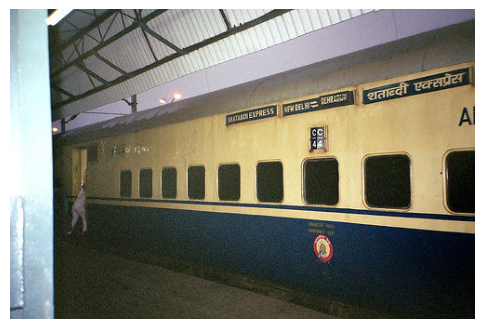

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(scale_img.numpy())
plt.axis('off')
plt.show()

In [21]:
norm_boxes = NormalizeBoundingBoxes()

In [22]:
norm_image, norm_targets = norm_boxes(scale_img, scale_target)

In [23]:
norm_targets

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float16, numpy=
 array([[0.1382, 0.022 , 1.    , 0.666 ],
        [0.1862, 0.38  , 0.2493, 0.486 ]], dtype=float16)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

## Photometric Transform Functions

In [24]:
class Compose:
    def __init__(self, transforms: list[Any]):
        self._transforms = transforms

    def __call__(self, image, target):
        for transform in self._transforms:
            image, target = transform(image,target)

            if image is None:
                raise RuntimeError(f"{transform} returned image=None")

            if target is None or "boxes" not in target or "labels" not in target:
                raise RuntimeError(f"{transform} returned invalid target")

        return image, target

In [25]:
class PhotometricDistort:
    def __init__(self, p: float =1.0, brightness_delta: float = 0.125, contrast_range: tuple[float, float] = (0.5, 1.5), saturation_range: tuple[float, float] = (0.5,1.5), hue_delta: float = 0.05, channel_swap: bool = False, seed: int| None = None):
        self._p = p
        self._brightness_delta = brightness_delta
        self._contrast_range = tuple(contrast_range)
        self._saturation_range = tuple(saturation_range)
        self._hue_delta = hue_delta
        self._channel_swap = channel_swap
        self._seed = seed
        
    def __call__(self, image, target):
        # Call early exit

        image = self.to_float(image)

        if self._p < 1.0:
            random_num = tf.random.uniform([])
            image = tf.cond(random_num < self._p, lambda: self.distort_image(image), lambda: image)
        else:
            image = self.distort_image(image)

        return image, target

    def distort_image(self, image):
        image = self.determine_outcome(lambda x: tf.image.random_brightness(x, self._brightness_delta,seed = self._seed), image)

        contrast_order = tf.random.uniform([], 0.0, 1.0, seed=self._seed) < 0.5

        image = tf.cond(contrast_order, lambda: self.contrast_first(image), lambda: self.contrast_last(image))

        if self._channel_swap:
            image = self.determine_outcome(self.random_channel_swap, image)

        return image

    def determine_outcome(self, function, image):
        random_num = tf.random.uniform([], 0.0, 1.0, seed=self._seed)
        return tf.cond(random_num < 0.5, lambda: function(image), lambda: image)
    
    def contrast_first(self,image):
        image = self.determine_outcome(lambda x: tf.image.random_contrast(x, self._contrast_range[0], self._contrast_range[1], seed=self._seed), image)
        image = self.determine_outcome(lambda x: tf.image.random_saturation(x, self._saturation_range[0], self._saturation_range[1], seed=self._seed), image)
        image = self.determine_outcome(lambda x: tf.image.random_hue(x, self._hue_delta, seed=self._seed), image)

        return image

    def contrast_last(self,image):
        image = self.determine_outcome(lambda x: tf.image.random_saturation(x, self._saturation_range[0], self._saturation_range[1], seed=self._seed), image)
        image = self.determine_outcome(lambda x: tf.image.random_hue(x, self._hue_delta, seed=self._seed), image)
        image = self.determine_outcome(lambda x: tf.image.random_contrast(x, self._contrast_range[0], self._contrast_range[1], seed=self._seed), image)

        return image

    def random_channel_swap(self, image):
        perm = tf.random.shuffle(tf.constant([0, 1, 2]), seed=self._seed)
        return tf.gather(image, perm, axis=-1)

    def to_float(self, image):
        return tf.cast(image, dtype = tf.float32)

In [26]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self._p = tf.constant(p, dtype = tf.float32)

    def __call__(self, image, target):
        random_num = tf.random.uniform([])

        image, target = tf.cond(random_num < self._p, lambda: self.horizontal_flip(image,target), lambda: self.dont_flip(image, target))

        return image, target
        
    @staticmethod
    def horizontal_flip(image,target):
        shape = tf.shape(image)
        W = tf.cast(shape[1], tf.float32)

        boxes = target['boxes']
        W = tf.cast(W, dtype = boxes.dtype)
        
        x_min, y_min, x_max, y_max = tf.split(boxes,num_or_size_splits = 4, axis=-1)

        # Flipping the Coordinates
        x_min_new = W - x_max
        x_max_new = W - x_min

        boxes = tf.concat([x_min_new,y_min,x_max_new,y_max],axis=-1)

        target['boxes'] = boxes

        # Flipping the image
        image_flipped = tf.image.flip_left_right(image)

        return image_flipped, target
    @staticmethod
    def dont_flip(image, target):
        return image, target

In [27]:
class Resize:
    def __init__(self, size: tuple[float, float] | int, mode="stretch"):
        if isinstance(size, int):
            self._size = (size, size)
        elif isinstance(size, tuple) and len(size) == 2:
            self._size = (int(size[0]), int(size[1]))
        else:
            raise ValueError("size must be int or tuple(h, w)")

        if mode not in ("stretch", "letterbox"):
            raise ValueError("mode must be 'stretch' or 'letterbox'")

        self._mode = mode

    def __call__(self, image, target):
        
        shape = tf.shape(image)
        H = tf.cast(shape[0], tf.float32)
        W = tf.cast(shape[1], tf.float32)

        new_h = tf.cast(self._size[0], tf.float32)
        new_w = tf.cast(self._size[1], tf.float32)

        boxes = tf.cast(target["boxes"], tf.float32)
        
        if self._mode == "stretch":
            scaled_x = new_w / W
            scaled_y = new_h / H 

            x1, y1, x2, y2 = tf.split(boxes, num_or_size_splits = 4, axis= -1)

            x1 = x1 * scaled_x
            y1 = y1 * scaled_y
            x2 = x2 * scaled_x
            y2 = y2 * scaled_y

            boxes = tf.concat([x1, y1, x2, y2], axis= -1)

            # Resizing image
            target_size = [self._size[0], self._size[1]]
            image = tf.image.resize(image, target_size)
            
        elif self._mode == "letterbox":
            scale = tf.minimum(new_h / H, new_w / W)
            
            resized_width = tf.cast(tf.floor(W * scale), tf.int32)
            resized_height = tf.cast(tf.floor(H * scale), tf.int32)

            # Resizing image
            image_resized = tf.image.resize(image, [resized_height, resized_width])

            padding_width = tf.cast(self._size[1], tf.int32) - resized_width
            padding_height = tf.cast(self._size[0], tf.int32) - resized_height

            pad_left = padding_width // 2
            pad_right = padding_width - pad_left
            pad_top = padding_height // 2
            pad_bottom = padding_height - pad_top

            image = tf.pad(image_resized, paddings = [[pad_top, pad_bottom],[pad_left, pad_right], [0,0]], mode= "CONSTANT", constant_values = 0.0)

            pad_x = tf.cast(pad_left, tf.float32)
            pad_y = tf.cast(pad_top, tf.float32)

            # Update box coordinates
            x1, y1, x2, y2 = tf.split(boxes, num_or_size_splits = 4, axis= -1)

            x1 = x1 * scale + pad_x
            y1 = y1 * scale + pad_y
            x2 = x2 * scale + pad_x
            y2 = y2 * scale + pad_y

            boxes = tf.concat([x1, y1, x2, y2], axis= -1)
            
        else:
            raise ValueError("")

        x1, y1, x2, y2 = tf.split(boxes, num_or_size_splits = 4, axis= -1)
        
        x1 = tf.clip_by_value(x1, 0.0, new_w)
        y1 = tf.clip_by_value(y1, 0.0, new_h)
        x2 = tf.clip_by_value(x2, 0.0, new_w)
        y2 = tf.clip_by_value(y2, 0.0, new_h)

        boxes = tf.concat([x1, y1, x2, y2], axis= -1)

        target['boxes'] = boxes

        target['resize_info'] = tf.constant(tf.cast([new_h, new_w], tf.float32),dtype = tf.float32)
        
        return image, target

In [28]:
class Normalize:
    def __init__(self, mean: list[float], std: list[float]):
        
        if len(mean) != 3 or len(std) != 3:
            raise ValueError("Normalize expects mean and std of length 3 (RGB).")
            
        self._mean = tf.constant(mean, dtype=tf.float32)[None, None, :]
        self._std = tf.constant(std,  dtype=tf.float32)[None, None, :]

    def __call__(self, image, target):
        original_dtype = image.dtype
        
        # Convert image to float32
        image = tf.cast(image, dtype = tf.float32)

        # Scale pixels from [0,255] to [0,1]
        if original_dtype.is_integer:
            image = image / 255.0

        # Applying channel wise normalization
        image = (image - self._mean) / self._std

        return image, target

In [29]:
class ClipAndFilterBoxes:
    def __init__(self, min_size: int = 1):
        self._min_size = float(min_size)

    def __call__(self, image: tf.Tensor, target: dict[str, Any]):
        # Clip boxes
        boxes = target['boxes']
        labels = target['labels']

        H, W, _ = tf.shape(image)

        H = tf.cast(H, dtype= tf.float32)
        W = tf.cast(W, dtype= tf.float32)

        boxes = tf.cast(boxes,dtype = tf.float32)

        # Clipping the coordinates
        x1, y1, x2, y2 = tf.split(boxes, num_or_size_splits = 4, axis = -1)

        x1 = tf.clip_by_value(x1, 0.0, W)
        y1 = tf.clip_by_value(y1, 0.0, H)
        x2 = tf.clip_by_value(x2, 0.0, W)
        y2 = tf.clip_by_value(y2, 0.0, H)

        boxes = tf.concat([x1,y1,x2,y2], axis = -1)

        # Checking which of the size is less than min

        w = x2 - x1
        h = y2 - y1

        min_size = tf.constant(self._min_size, dtype = tf.float32)

        valid_width = w >= min_size
        valid_height = h >= min_size

        size_valid = tf.logical_and(valid_width, valid_height)

        size_valid = tf.squeeze(size_valid, axis = -1)

        # Filtering them out
        valid_boxes = tf.boolean_mask(boxes, size_valid)
        valid_labels = tf.boolean_mask(labels, size_valid)


        target['labels'] = valid_labels
        target['boxes'] = valid_boxes


        return image, target

In [30]:
from datasets.voc import VOCDataset
import matplotlib.pyplot as plt
import numpy as np

In [31]:
data = VOCDataset(config, "val")

In [32]:
image, target = data[3]

In [33]:
target

{'boxes': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[217., 161., 294., 221.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000009'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'c9f97a34ac4fed61aa5ebe5acdfaab7a'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 375], dtype=int32)>}

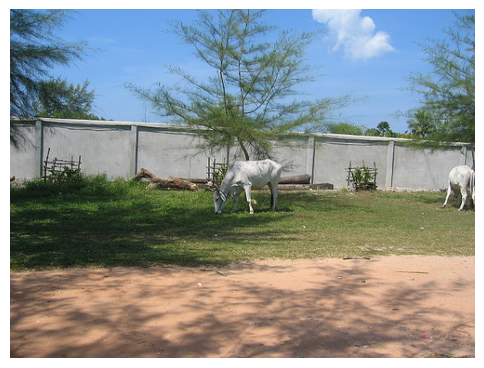

In [34]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy() / 255)
plt.axis('off')
plt.show()

In [35]:
horizontal_flip = RandomHorizontalFlip(p = 1.0)

In [36]:
hflip_image, flip_target = horizontal_flip(image, target)

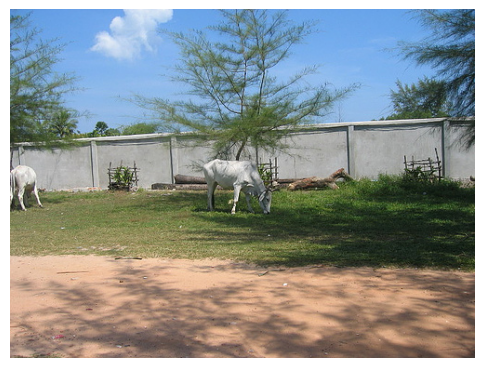

In [37]:
plt.figure(figsize=(6, 6))
plt.imshow(hflip_image.numpy() / 255)
plt.axis('off')
plt.show()

In [38]:
flip_target

{'boxes': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[206., 161., 283., 221.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000009'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'c9f97a34ac4fed61aa5ebe5acdfaab7a'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 375], dtype=int32)>}

In [39]:
resize= Resize(size = (300,300), mode = "letterbox")

In [40]:
image, target = data[1]

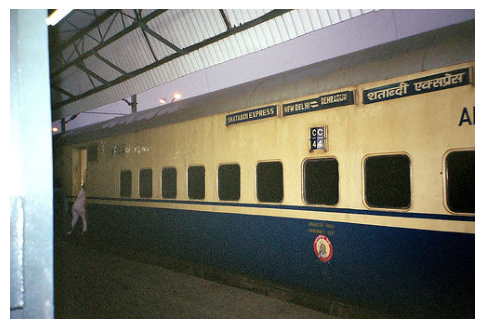

In [41]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy() / 255)
plt.axis('off')
plt.show()

In [42]:
resize_image, resize_target = resize(image, target)

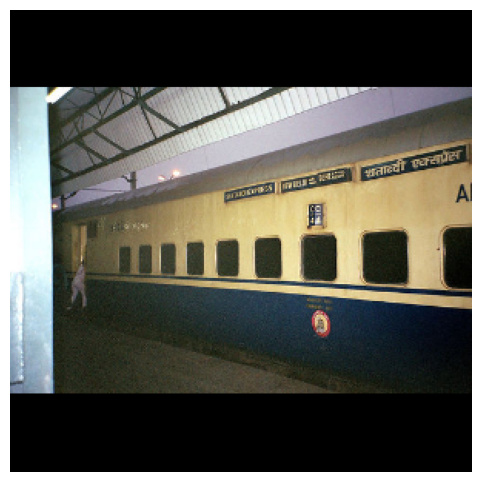

In [43]:
plt.figure(figsize=(6, 6))
plt.imshow(resize_image.numpy() / 255)
plt.axis('off')
plt.show()

In [44]:
resize_target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 27.6     ,  56.6     , 199.8     , 249.8     ],
        [ 37.2     , 164.      ,  49.800003, 195.8     ]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>,
 'resize_info': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([300., 300.], dtype=float32)>}

In [45]:
image, target = data[1]

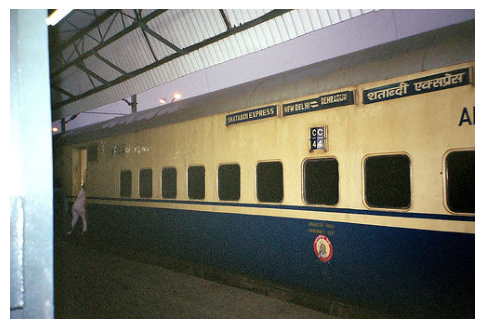

In [46]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy() / 255)
plt.axis('off')
plt.show()

In [47]:
normalize = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [48]:
normalize_image, normalize_target = normalize(image, target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


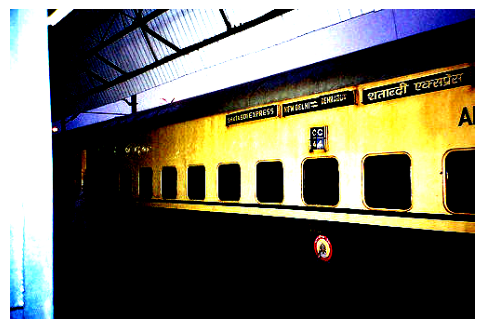

In [49]:
plt.figure(figsize=(6, 6))
plt.imshow(normalize_image.numpy())
plt.axis('off')
plt.show()

In [50]:
image, target = data[1]

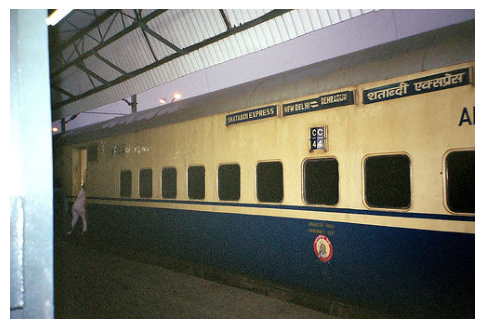

In [51]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy() / 255)
plt.axis('off')
plt.show()

In [52]:
target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 46.,  11., 333., 333.],
        [ 62., 190.,  83., 243.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

In [53]:
clip = ClipAndFilterBoxes(min_size = 100)

In [54]:
clip_image, clip_boxes = clip(image,target)

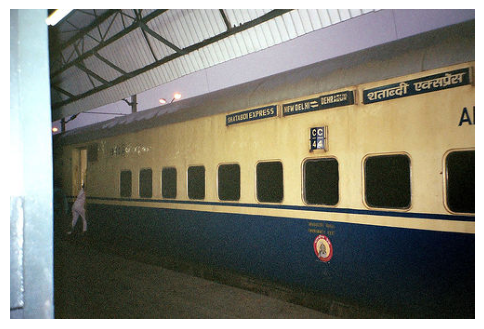

In [55]:
plt.figure(figsize=(6, 6))
plt.imshow(clip_image.numpy())
plt.axis('off')
plt.show()

In [56]:
clip_boxes

{'boxes': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 46.,  11., 333., 333.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

In [57]:
image, target = data[1]

In [58]:
target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 46.,  11., 333., 333.],
        [ 62., 190.,  83., 243.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

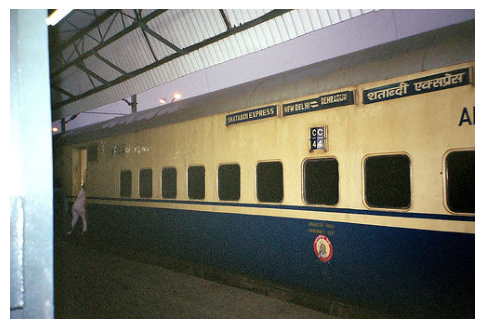

In [59]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy() / 255)
plt.axis('off')
plt.show()

In [60]:
photometric_distort = PhotometricDistort()

In [61]:
distort_image, distort_target = photometric_distort(image / 255, target)

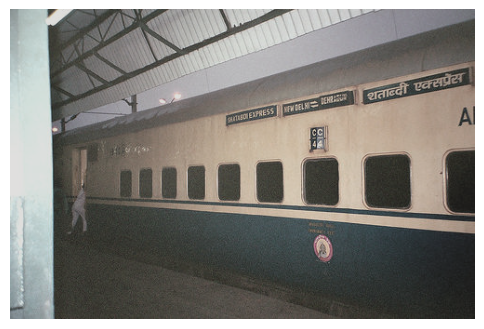

In [62]:
plt.figure(figsize=(6, 6))
plt.imshow(distort_image.numpy())
plt.axis('off')
plt.show()

In [63]:
distort_target

{'boxes': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 46.,  11., 333., 333.],
        [ 62., 190.,  83., 243.]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19, 15], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>}

In [64]:
distort_image

<tf.Tensor: shape=(333, 500, 3), dtype=float32, numpy=
array([[[0.5101088 , 0.5512899 , 0.5467636 ],
        [0.51748186, 0.5590663 , 0.555888  ],
        [0.53480804, 0.57625407, 0.5802198 ],
        ...,
        [0.4492806 , 0.44277015, 0.47985104],
        [0.45673382, 0.44968185, 0.49201697],
        [0.46585828, 0.45880628, 0.5011414 ]],

       [[0.5253163 , 0.5664973 , 0.56197095],
        [0.5326893 , 0.57427365, 0.5710954 ],
        [0.5439325 , 0.5853785 , 0.58934426],
        ...,
        [0.4532435 , 0.461286  , 0.4828925 ],
        [0.45453358, 0.46297935, 0.48593402],
        [0.45757505, 0.46602082, 0.4889755 ]],

       [[0.54181373, 0.58339804, 0.5802198 ],
        [0.5448552 , 0.58643955, 0.5832613 ],
        [0.55351824, 0.59415776, 0.5954272 ],
        ...,
        [0.42411876, 0.44132167, 0.4555192 ],
        [0.42411876, 0.44132167, 0.4555192 ],
        [0.42107728, 0.43828017, 0.45247775]],

       ...,

       [[0.44992003, 0.49270245, 0.5163488 ],
        [0.45

In [65]:
compose = Compose(transforms = [
    RandomHorizontalFlip(p = 1.0),
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    PhotometricDistort(),
    Resize(size = (300,300), mode = "letterbox"),
    ClipAndFilterBoxes(min_size = 100),
    
])

In [66]:
image, target = data[1]

In [67]:
compose_img, compose_target = compose(image,target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8167..2.6277447].


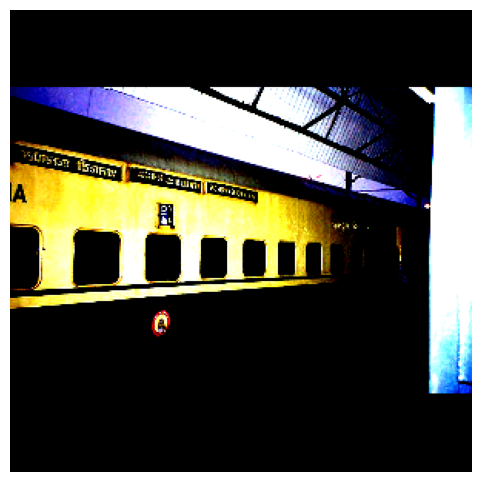

In [68]:
plt.figure(figsize=(6, 6))
plt.imshow(compose_img.numpy())
plt.axis('off')
plt.show()

In [69]:
compose_target

{'boxes': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[100.200005,  56.6     , 272.40002 , 249.8     ]], dtype=float32)>,
 'labels': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([19], dtype=int32)>,
 'path': <tf.Tensor: shape=(), dtype=string, numpy=b'/mnt/d/dev/MobileNetV2-SSD/datasets/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg'>,
 'image_id': <tf.Tensor: shape=(), dtype=string, numpy=b'2008_000003'>,
 'hash_signature': <tf.Tensor: shape=(), dtype=string, numpy=b'f04347d1d1f5891c2145b6053c5888d9'>,
 'orig_size': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([500, 333], dtype=int32)>,
 'resize_info': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([300., 300.], dtype=float32)>}

## Builder Functions

In [70]:
def build_preprocess_pipeline(config: dict[str, Any]):
    preprocesss_opts = config['data'].get('preprocess', {})
    preprocess_params = preprocesss_opts.get('params', {})
    preprocess_config = {
        'standardize_pipeline': preprocesss_opts.get('standardize_pipeline', ['to_float32', 'scale_01']),
        'pipeline': preprocesss_opts.get('pipeline', ['resize', 'sanitize_boxes','normalize']),
        'params': {
            'resize': {
                'enabled': preprocess_params.get('resize', {}).get('enabled', False),
                'size': preprocess_params.get('resize', {}).get('size', [224, 224]),
                'mode': preprocess_params.get('resize', {}).get('mode', 'stretch'),
                'interp': preprocess_params.get('resize', {}).get('interp', 'bilinear'),
            },
            'sanitize_boxes': {
                'enabled': preprocess_params.get('sanitize_boxes', {}).get('enabled', False),
                'clip': preprocess_params.get('sanitize_boxes', {}).get('clip', False),
                'min_size': preprocess_params.get('sanitize_boxes', {}).get('min_size', 1),
                'min_size_mode': preprocess_params.get('sanitize_boxes', {}).get('min_size_mode', 'pixels'),
            },
            'normalize': {
                'enabled': preprocess_params.get('normalize', {}).get('enabled', False),
                'mean': preprocess_params.get('normalize', {}).get('mean', [0.485, 0.456, 0.406]),
                'std': preprocess_params.get('normalize', {}).get('std', [0.229, 0.224, 0.225]),
            }
        }
    }

    return preprocess_config

In [71]:
preprocess_config = build_preprocess_pipeline(config)

In [72]:
preprocess_config

{'standardize_pipeline': ['to_float32', 'scale_01'],
 'pipeline': ['resize', 'sanitize_boxes', 'normalize'],
 'params': {'resize': {'enabled': True,
   'size': [300, 300],
   'mode': 'stretch',
   'interp': 'bilinear'},
  'sanitize_boxes': {'enabled': True,
   'clip': True,
   'min_size': 1,
   'min_size_mode': 'pixels'},
  'normalize': {'enabled': True,
   'mean': [0.485, 0.456, 0.406],
   'std': [0.229, 0.224, 0.225]}}}

In [73]:
def build_train_augmentation_config(config: dict[str, Any]):
    augment_opts = config['data'].get('augment', {})
    augment_params = augment_opts.get('params', {})

    augment_config = {
        'enabled' : augment_opts.get('enabled', False),
        'output_box_norm': augment_opts.get('output_box_norm', False),
        'pipeline': augment_opts.get('pipeline', ['photometric_distort','random_flip','resize','sanitize_boxes','normalize']),
        'params': {
            'random_flip': {
                'enabled': augment_params.get('random_flip', {}).get('enabled', False),
                'prob': augment_params.get('random_flip', {}).get('prob', 0.1),
                'direction': augment_params.get('random_flip', {}).get('direction', 'horizontal'),
            },
            'random_iou_crop': {
                'enabled': augment_params.get('random_iou_crop', {}).get('enabled', False),
                'prob': augment_params.get('random_iou_crop', {}).get('prob', 0.1),
                'min_iou_choices': augment_params.get('random_iou_crop', {}).get('min_iou_choices', []),
                'min_scale': augment_params.get('random_iou_crop', {}).get('min_scale', 0.3),
                'max_scale': augment_params.get('random_iou_crop', {}).get('max_scale', 1.0),
                'max_attempts': augment_params.get('random_iou_crop', {}).get('max_attempts', 50),
                'fallback': augment_params.get('random_iou_crop', {}).get('fallback', 'original'),
            },
            'random_expand': {
                'enabled': augment_params.get('random_expand', {}).get('enabled', False),
                'prob': augment_params.get('random_expand', {}).get('prob', 0.1),
                'max_ratio': augment_params.get('random_expand', {}).get('max_ratio', 3.0),
                'fill': augment_params.get('random_expand', {}).get('fill', 'mean'),
                'value': augment_params.get('random_expand', {}).get('value', [0.485, 0.456, 0.406]),
            },
            'photometric_distort': {
                'enabled': augment_params.get('photometric_distort', {}).get('enabled', False),
                'prob': augment_params.get('photometric_distort', {}).get('prob', 0.1),
                'brightness': augment_params.get('photometric_distort', {}).get('brightness', 0.125),
                'contrast': augment_params.get('photometric_distort', {}).get('contrast', [0.5, 1.5]),
                'saturation': augment_params.get('photometric_distort', {}).get('saturation', [0.5, 1.5]),
                'hue': augment_params.get('photometric_distort', {}).get('hue', 0.5),
                'random_order': augment_params.get('photometric_distort', {}).get('random_order', True),
            },
            'resize': {
                'enabled': augment_params.get('resize', {}).get('enabled', False),
                'size': augment_params.get('resize', {}).get('size', [300, 300]),
                'mode': augment_params.get('resize', {}).get('mode', 'stretch'),
                'interp': augment_params.get('resize', {}).get('interp', 'bilinear'),
            },
            'sanitize_boxes': {
                'enabled': augment_params.get('sanitize_boxes', {}).get('enabled', False),
                'clip': augment_params.get('sanitize_boxes', {}).get('clip', False),
                'min_size': augment_params.get('sanitize_boxes', {}).get('min_size', 1),
                'min_size_mode': augment_params.get('sanitize_boxes', {}).get('min_size_mode', 'pixels'),
            },
            'normalize': {
                'enabled': augment_params.get('normalize', {}).get('enabled', False),
                'mean': augment_params.get('normalize', {}).get('mean', [0.485, 0.456, 0.406]),
                'std': augment_params.get('normalize', {}).get('std', [0.229, 0.224, 0.225]),
            }
        }
    }

    return augment_config

In [74]:
def build_validation_augmentation_config(config: dict[str, Any]):
    validation_opts = config['data'].get('val_preprocess', {})
    validation_params = validation_opts.get('params', {})

    validation_config = {
        'pipeline': validation_opts.get('pipeline', ['resize','sanitize_boxes','normalize']),
        'standardize_pipeline': validation_opts.get('standardize_pipeline', ['to_float32', 'scale_01']),
        'output_box_norm': validation_opts.get('output_box_norm', False),
        'params': {
            'resize': {
                'enabled': validation_params.get('resize', {}).get('enabled', False),
                'size': validation_params.get('resize', {}).get('size', [300, 300]),
                'mode': validation_params.get('resize', {}).get('mode', 'stretch'),
                'interp': validation_params.get('resize', {}).get('interp', 'bilinear'),
            },
            'sanitize_boxes': {
                'enabled': validation_params.get('sanitize_boxes', {}).get('enabled', False),
                'clip': validation_params.get('sanitize_boxes', {}).get('clip', False),
                'min_size': validation_params.get('sanitize_boxes', {}).get('min_size', 1),
                'min_size_mode': validation_params.get('sanitize_boxes', {}).get('min_size_mode', 'pixels'),
            },
            'normalize': {
                'enabled': validation_params.get('normalize', {}).get('enabled', False),
                'mean': validation_params.get('normalize', {}).get('mean', [0.485, 0.456, 0.406]),
                'std': validation_params.get('normalize', {}).get('std', [0.229, 0.224, 0.225]),
            }
        }
    }

    return validation_config

In [75]:
build_validation_augmentation_config(config)

{'pipeline': ['resize', 'sanitize_boxes', 'normalize'],
 'standardize_pipeline': ['to_float32', 'scale_01'],
 'output_box_norm': True,
 'params': {'resize': {'enabled': True,
   'size': [224, 224],
   'mode': 'stretch',
   'interp': 'bilinear'},
  'sanitize_boxes': {'enabled': True,
   'clip': True,
   'min_size': 1,
   'min_size_mode': 'pixels'},
  'normalize': {'enabled': True,
   'mean': [0.485, 0.456, 0.406],
   'std': [0.229, 0.224, 0.225]}}}

In [76]:
build_train_augmentation_config(config)['pipeline']

['photometric_distort', 'random_expand', 'random_iou_crop', 'random_flip']

In [77]:
def build_validation_transforms(config: dict[str, Any]):
    augment_config = build_validation_augmentation_config(config)

    # Building the config based on the pipeline
    transform_list = []
    # Iterating over the preprocess config
    for preprocess_transform in augment_config['standardize_pipeline']:
         match preprocess_transform:
            case 'to_float32':
                float_transform = ToFloat32()
                transform_list.append(float_transform)
            case 'scale_01':
                scale = Scale01()
                transform_list.append(scale)
    
    # Iterating over the augmentation transforms
    for key in augment_config['pipeline']:
        if not augment_config['params'][key]['enabled']:
            continue

        # Parse the config based on the type
        match key:
            case 'resize':
                target_size = augment_config['params'][key]['size']
                mode = augment_config['params'][key]['mode']
                transform_list.append(Resize(size = tuple(target_size), mode = mode))
            case 'sanitize_boxes':
                min_size = augment_config['params'][key]['min_size']
                transform_list.append(ClipAndFilterBoxes(min_size = min_size))
            case 'normalize':
                mean = augment_config['params'][key]['mean']
                std = augment_config['params'][key]['std']
                transform_list.append(Normalize(mean = mean, std = std))
            case _:
                raise ValueError("Wrong Transform type present in the config")

    # Last part to check for normalization
    if augment_config['output_box_norm']:
        # Normalize the boxes
        normal_bboxes = NormalizeBoundingBoxes()
        transform_list.append(normal_bboxes)

    compose = Compose(transforms = transform_list)

    return compose

In [78]:
def build_train_transforms(config: dict[str, Any]):
    augment_config = build_train_augmentation_config(config)

    preprocess_config = build_preprocess_pipeline(config)

    # Building the config based on the pipeline
    transform_list = []
    # Iterating over the preprocess config
    for preprocess_transform in preprocess_config['standardize_pipeline']:
         match preprocess_transform:
            case 'to_float32':
                float_transform = ToFloat32()
                transform_list.append(float_transform)
            case 'scale_01':
                scale = Scale01()
                transform_list.append(scale)
    
    # Iterating over the augmentation transforms
    for key in augment_config['pipeline']:
        if not augment_config['params'][key]['enabled']:
            continue

        # Parse the config based on the type
        match key:
            case 'random_flip':
                if augment_config['params'][key]['direction'] == 'horizontal':
                    flip = RandomHorizontalFlip(p = augment_config['params'][key]['prob'])
                else:
                    pass

                transform_list.append(flip)
            case 'random_iou_crop':
                pass
            case 'random_expand':
                pass
            case 'photometric_distort':
                p = augment_config['params'][key]['prob']
                brightness_delta = augment_config['params'][key]['brightness']
                contrast_range = augment_config['params'][key]['contrast']
                saturation_range = augment_config['params'][key]['saturation']
                hue_delta = augment_config['params'][key]['hue']
                channel_swap = augment_config['params'][key]['random_order']
                transform_list.append(PhotometricDistort(p = p, brightness_delta = brightness_delta, contrast_range = contrast_range,saturation_range = saturation_range,hue_delta = hue_delta, channel_swap = channel_swap))
            case _:
                raise ValueError("Wrong Transform type present in the config")


    # Last Part of the pipeline
    for key in preprocess_config['pipeline']:
        if not preprocess_config['params'][key]['enabled']:
            continue

        # Parse the config based on the type
        match key:
            case 'resize':
                target_size = preprocess_config['params'][key]['size']
                mode = preprocess_config['params'][key]['mode']
                transform_list.append(Resize(size = tuple(target_size), mode = mode))
            case 'sanitize_boxes':
                min_size = preprocess_config['params'][key]['min_size']
                transform_list.append(ClipAndFilterBoxes(min_size = min_size))
            case 'normalize':
                mean = preprocess_config['params'][key]['mean']
                std = preprocess_config['params'][key]['std']
                transform_list.append(Normalize(mean = mean, std = std))
            case _:
                raise ValueError("Wrong Transform type present in the config")


    # Last part to check for normalization
    if augment_config['output_box_norm']:
        # Normalize the boxes
        normal_bboxes = NormalizeBoundingBoxes()
        transform_list.append(normal_bboxes)

    compose = Compose(transforms = transform_list)

    return compose

In [79]:
augment_config = build_train_augmentation_config(config)

In [80]:
transform_list = []
for key in augment_config['pipeline']:
    if not augment_config['params'][key]['enabled']:
        continue

    # Parse the config based on the type
    match key:
        case 'random_flip':
            if augment_config['params'][key]['direction'] == 'horizontal':
                flip = RandomHorizontalFlip(p = augment_config['params'][key]['prob'])
            else:
                pass

            transform_list.append(flip)
        case 'random_iou_crop':
            pass
        case 'random_expand':
            pass
        case 'photometric_distort':
            p = augment_config['params'][key]['prob']
            brightness_delta = augment_config['params'][key]['brightness']
            contrast_range = augment_config['params'][key]['contrast']
            saturation_range = augment_config['params'][key]['saturation']
            hue_delta = augment_config['params'][key]['hue']
            channel_swap = augment_config['params'][key]['random_order']
            transform_list.append(PhotometricDistort(p = p, brightness_delta = brightness_delta, contrast_range = contrast_range,saturation_range = saturation_range,hue_delta = hue_delta, channel_swap = channel_swap))
        case 'resize':
            target_size = augment_config['params'][key]['size']
            mode = augment_config['params'][key]['mode']
            transform_list.append(Resize(size = tuple(target_size), mode = mode))
        case 'sanitize_boxes':
            min_size = augment_config['params'][key]['min_size']
            transform_list.append(ClipAndFilterBoxes(min_size = min_size))
        case 'normalize':
            mean = augment_config['params'][key]['mean']
            std = augment_config['params'][key]['std']
            transform_list.append(Normalize(mean = mean, std = std))
        case _:
            raise ValueError("Wrong Transform type present in the config")

In [81]:
transform_list

In [82]:
compose = build_train_transforms(config)

In [83]:
compose._transforms

In [84]:
val_compose = build_validation_transforms(config)

In [85]:
val_compose._transforms

In [86]:
image, target = data[1]

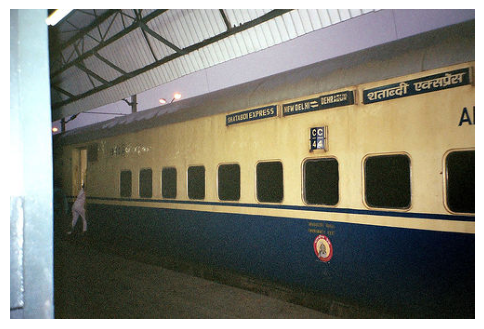

In [87]:
plt.figure(figsize=(6, 6))
plt.imshow(image.numpy())
plt.axis('off')
plt.show()

In [88]:
compose_img, compose_target = compose(image,target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


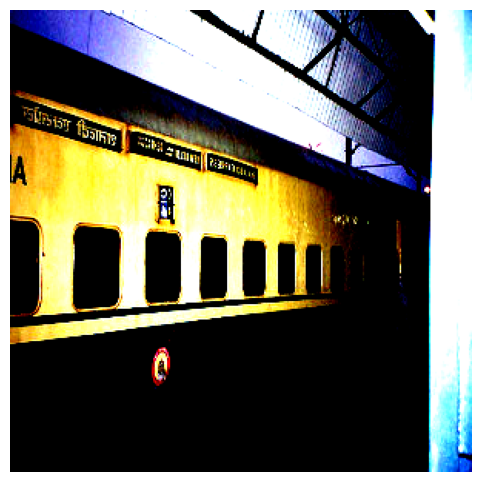

In [89]:
plt.figure(figsize=(6, 6))
plt.imshow(compose_img.numpy())
plt.axis('off')
plt.show()